In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
import numpy as np
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt  
import copy
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier


In [2]:
dataset = pd.read_csv("out.csv")
dataset.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,-1,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,-1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,-1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,-1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,-1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Setting Class Column

In [3]:
i = 0

print(dataset['class'][0])
for a,b,c in zip(dataset['hate_speech'] , dataset['offensive_language'] , dataset['neither']):
    if(a>b and a>c):
        dataset['class'][i] = 0

    elif(b>a and b>c):
        dataset['class'][i] = 1
    
    else:
        dataset['class'][i] = 2
                
    i+=1
    

dataset.head()



-1


<ipython-input-3-2bf9112c918b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['class'][i] = 2
<ipython-input-3-2bf9112c918b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['class'][i] = 1
<ipython-input-3-2bf9112c918b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['class'][i] = 0


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
# Adding text-length as a field in the dataset
dataset['text length'] = dataset['tweet'].apply(len)
print( dataset.head() )

   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  text length  
0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  


# Data Visualization

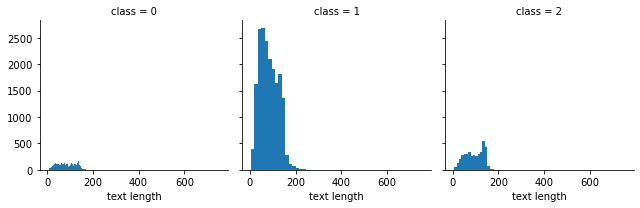

In [5]:
#Basic visualization of data using histograms
import seaborn as sns
import matplotlib.pyplot as plt

graph = sns.FacetGrid(data=dataset, col='class')
graph.map(plt.hist, 'text length', bins=50)

#0 = hate , 1 = Offensive and 2 = neither

<AxesSubplot:>

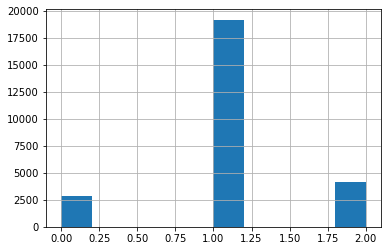

In [6]:
dataset['class'].hist()

# Preprocessing

In [7]:
tweet=dataset.tweet
print(type(tweet))
tweet 

<class 'pandas.core.series.Series'>


0        !!! RT @mayasolovely: As a woman you shouldn't...
1        !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2        !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3        !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4        !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
                               ...                        
26208                  this guy is the biggest faggot omfg
26209    which one of these names is more offensive kik...
26210           you a pussy ass nigga and I know it nigga.
26211                                   you're all niggers
26212    you're such a retard i hope you get type 2 dia...
Name: tweet, Length: 26213, dtype: object

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shahzaib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
## 1. Removal of punctuation and capitlization
## 2. Tokenizing
## 3. Removal of stopwords
## 4. Stemming

stop_words = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stop_words.extend(other_exclusions)

def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    new_tweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    new_tweet=new_tweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    new_tweet=new_tweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = new_tweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stop_words])
    
    for i in range(len(tokenized_tweet)):
        if i < 5:
            print(tokenized_tweet[i])
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
        if i < 5:
            print(tokenized_tweet[i])
        tweets_p= tokenized_tweet
    
    return tweets_p

processed_tweets = preprocess(tweet)   

dataset['processed_tweets'] = processed_tweets
print(dataset["tweet"].head(10),dataset["processed_tweets"].head(10))

['woman', 'complain', 'cleaning', 'house', 'amp', 'man', 'always', 'take', 'trash']
woman complain cleaning house amp man always take trash
['boy', 'dats', 'cold', 'tyga', 'dwn', 'bad', 'cuffin', 'dat', 'hoe', 'st', 'place']
boy dats cold tyga dwn bad cuffin dat hoe st place
['dawg', 'ever', 'fuck', 'bitch', 'start', 'cry', 'confused', 'shit']
dawg ever fuck bitch start cry confused shit
['look', 'like', 'tranny']
look like tranny
['shit', 'hear', 'might', 'true', 'might', 'faker', 'bitch', 'told', 'ya']
shit hear might true might faker bitch told ya
0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5    !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6    !!!!!!"@__BrighterDays: I can not just sit up ...
7    !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8  

# Transforming tweets into TFIDF vectors

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )

In [11]:
matrix = pd.DataFrame(tfidf.toarray())
matrix

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Running models using TFIDF score

In [12]:
# If you don't specify the random_state in the code, 
# then every time you run(execute) your code a new random value is generated 
# and the train and test datasets would have different values each time.
X = tfidf
y = dataset['class'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.2)

print("Training split input- ", X_train_tfidf.shape)   # X FOR INPUT
print("Testing split input- ", X_test_tfidf.shape)

print("\n\nY : Training split input- ", y_train.shape) # Y FOR TARGET.
print("Y : Testing split input- ", y_test.shape)


Training split input-  (20970, 10000)
Testing split input-  (5243, 10000)


Y : Training split input-  (20970,)
Y : Testing split input-  (5243,)


# Random Forest

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       552
           1       0.96      0.95      0.95      3833
           2       0.86      0.89      0.87       858

    accuracy                           0.93      5243
   macro avg       0.89      0.90      0.89      5243
weighted avg       0.93      0.93      0.93      5243

Random Forest, Accuracy Score: 0.9298111768071715
     0     1    2
0  473    63   16
1   81  3640  112
2    8    88  762


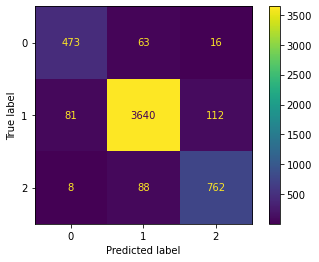

In [13]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)

y_predictions = rf.predict(X_test_tfidf)
report = classification_report( y_test, y_predictions)
print(report)
acc_rf=accuracy_score(y_test,y_predictions)
print("Random Forest, Accuracy Score:" , acc_rf)

dff = pd.DataFrame(confusion_matrix(y_test,y_predictions))
print(dff)

plot_confusion_matrix(rf, X_test_tfidf, y_test)  
plt.show()

# SVM

              precision    recall  f1-score   support

           0       0.74      0.66      0.70       552
           1       0.92      0.94      0.93      3833
           2       0.86      0.82      0.84       858

    accuracy                           0.89      5243
   macro avg       0.84      0.81      0.82      5243
weighted avg       0.89      0.89      0.89      5243

SVM Accuracy Score: 0.8933816517261111
     0     1    2
0  365   175   12
1  109  3619  105
2   16   142  700


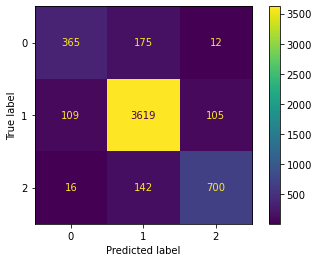

In [14]:
support = LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_predictions = support.predict(X_test_tfidf)
acc_svm=accuracy_score(y_test,y_predictions)
report = classification_report( y_test, y_predictions )
print(report)
print("SVM Accuracy Score:" , acc_svm)

dff = pd.DataFrame(confusion_matrix(y_test,y_predictions))
print(dff)

plot_confusion_matrix(support, X_test_tfidf, y_test)  
plt.show()  

# LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       0.71      0.42      0.53       552
           1       0.89      0.95      0.92      3833
           2       0.84      0.81      0.83       858

    accuracy                           0.87      5243
   macro avg       0.82      0.73      0.76      5243
weighted avg       0.87      0.87      0.87      5243

Logistic Regression, Accuracy Score: 0.8748807934388709
     0     1    2
0  230   282   40
1   83  3658   92
2   10   149  699


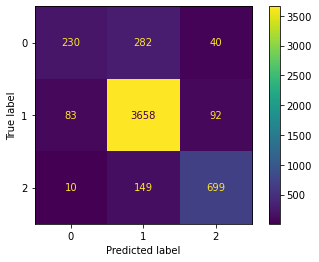

In [15]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf,y_train)
y_predictions = model.predict(X_test_tfidf)
report = classification_report( y_test, y_predictions )
print(report)
acc_lg=accuracy_score(y_test,y_predictions)
print("Logistic Regression, Accuracy Score:" , acc_lg)

dff = pd.DataFrame(confusion_matrix(y_test,y_predictions))
print(dff)

plot_confusion_matrix(model, X_test_tfidf, y_test)  
plt.show()  

# Finding the best K value for KNN

Minimum error:- 0.19168415029563227 at K = 17


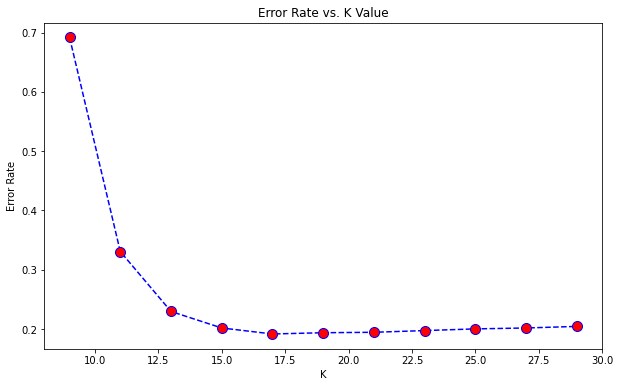

In [16]:
# FOR SELECTING BEST VALUE OF K.

error_rate = []

for i in range(9,30 , 2):    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_tfidf , y_train)
    pred_i = knn.predict(X_test_tfidf)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(9 , 30 , 2),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
k = 2 *error_rate.index(min(error_rate))+ 9
print("Minimum error:-",min(error_rate),"at K =",k )

# KNN for K = 17

              precision    recall  f1-score   support

           0       0.64      0.30      0.40       552
           1       0.83      0.94      0.88      3833
           2       0.71      0.57      0.63       858

    accuracy                           0.81      5243
   macro avg       0.73      0.60      0.64      5243
weighted avg       0.79      0.81      0.79      5243

Knn, Accuracy Score: 0.8083158497043678
     0     1    2
0  163   347   42
1   83  3590  160
2    7   366  485


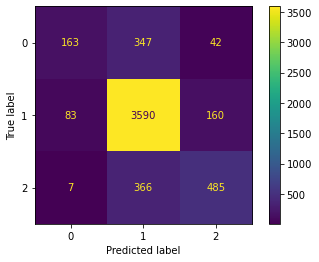

In [17]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train_tfidf,y_train)
y_predictions = knn.predict(X_test_tfidf)
report = classification_report( y_test, y_predictions)
print(report)
acc_knn=accuracy_score(y_test,y_predictions)
print("Knn, Accuracy Score:" , acc_knn)

dff = pd.DataFrame(confusion_matrix(y_test,y_predictions))
print(dff)

plot_confusion_matrix(knn, X_test_tfidf, y_test)  
plt.show()  

# Naive Bayes

              precision    recall  f1-score   support

           0       0.73      0.38      0.50       552
           1       0.85      0.96      0.91      3833
           2       0.84      0.62      0.71       858

    accuracy                           0.85      5243
   macro avg       0.81      0.65      0.71      5243
weighted avg       0.84      0.85      0.83      5243

Logistic Regression, Accuracy Score: 0.8458897577722678
     0     1    2
0  209   320   23
1   60  3697   76
2   19   310  529


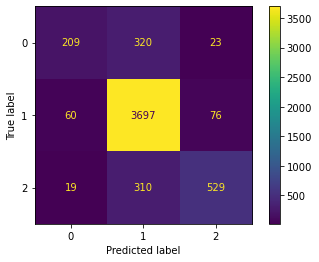

In [18]:
nb = BernoulliNB()
nb.fit(X_train_tfidf,y_train)
y_predictions = nb.predict(X_test_tfidf)
report = classification_report( y_test, y_predictions )
print(report)
acc_nb=accuracy_score(y_test,y_predictions)
print("Logistic Regression, Accuracy Score:" , acc_nb)

dff = pd.DataFrame(confusion_matrix(y_test,y_predictions))
print(dff)

plot_confusion_matrix(nb, X_test_tfidf, y_test)  
plt.show()

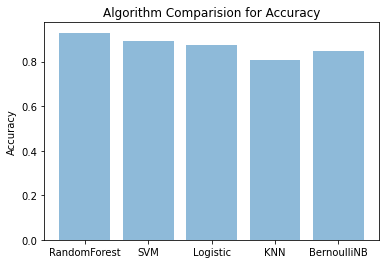

In [19]:
objects = ('RandomForest','SVM', 'Logistic', 'KNN' , 'BernoulliNB')
y_pos = np.arange(len(objects))
performance = [acc_rf,acc_svm,acc_lg,acc_knn,acc_nb]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('Algorithm Comparision for Accuracy')
plt.show()

# Predicting Realtime Query

In [37]:
query = input("Enter query for prediction: ")
query_series = pd.Series(query)
processed_query = preprocess(query_series)
processed_query = processed_query.iloc[0]
print(processed_query)

Enter query for prediction: i love muneeb
['love', 'muneeb']
love muneeb
love muneeb


In [38]:
corpus_vocabulary = defaultdict(None, copy.deepcopy(tfidf_vectorizer.vocabulary_))
tfidf_transformer_query_sec = TfidfVectorizer(vocabulary=corpus_vocabulary)
query_tfidf_matrix = tfidf_transformer_query_sec.fit_transform([processed_query])

str1_pred = rf.predict(query_tfidf_matrix)

if str1_pred[0] == 0:
    print('Hate')
if str1_pred[0] == 1:
    print('Offence')
if str1_pred[0] == 2:
    print('Neither')


Neither
